In [1]:
from NMF_Implementation.Noise import salt_and_pepper
from NMF_Implementation.L2Norm import Algorithm as L2Norm
from NMF_Implementation.L21Norm import Algorithm as L21Norm
from NMF_Implementation.base import load_data
from notebook_tools import reconstruction_error_sample, show_images
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

image_size = 30, 37
Xo, Yo = load_data('../data/ORL', image_size)
Xy, Yy = load_data('../data/CroppedYaleB', image_size)
Xo = Xo
Xy = Xy

/home/alexe/Documents/comp5328-a1/Notebooks/NMF_Implementation/base.py:84: UserWarning: could not handle person ../data/ORL/.DS_Store. Skipping...
  warnings.warn(f'could not handle person {person}. Skipping...')
/home/alexe/Documents/comp5328-a1/Notebooks/NMF_Implementation/base.py:84: UserWarning: could not handle person ../data/ORL/README. Skipping...
  warnings.warn(f'could not handle person {person}. Skipping...')
/home/alexe/Documents/comp5328-a1/Notebooks/NMF_Implementation/base.py:84: UserWarning: could not handle person ../data/CroppedYaleB/.DS_Store. Skipping...
  warnings.warn(f'could not handle person {person}. Skipping...')


(32, 37, 30)


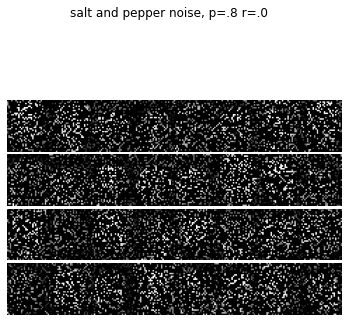

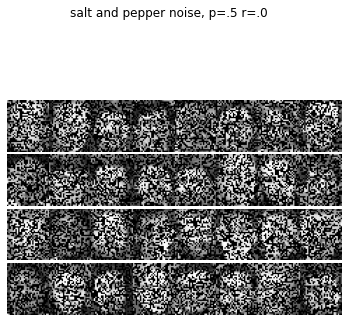

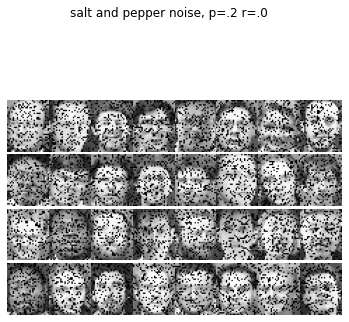

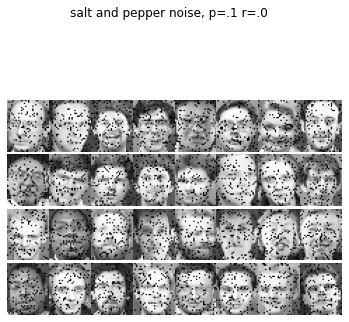

In [2]:
# our student numbers combined
np.random.seed(500407020 + 500175059)

# select number of images to show and dimensions
show_image_dims = 4, 8
show_image_count = np.product(show_image_dims)

# select images to show
show_yale = Xy[np.random.choice(Xy.shape[0], 32)]
show_orl = Xo[np.random.choice(Xo.shape[0], 32)]

print(show_orl.shape)
show_images(salt_and_pepper(show_orl, .8, 0.0), 'salt and pepper noise, p=.8 r=.0', show_image_dims)
plt.show()
show_images(salt_and_pepper(show_orl, .5, 0.0), 'salt and pepper noise, p=.5 r=.0', show_image_dims)
plt.show()
show_images(salt_and_pepper(show_orl, .2, 0.0), 'salt and pepper noise, p=.2 r=.0', show_image_dims)
plt.show()
show_images(salt_and_pepper(show_orl, .1, 0.0), 'salt and pepper noise, p=.1 r=.0', show_image_dims)
plt.show()

In [3]:
def k_reconstruct_relationship(nmf_algorithm, krange, named_noisefunctions, dataset):
    res = []
    iteration = 0
    for k in krange:
        for noise_name, noise_func in named_noisefunctions:
            out = reconstruction_error_sample(dataset, lambda: nmf_algorithm(k, stop_threshold=0.001), noise_func)
            sum_iterations = 0
            for o in out:
                o['k'] = k
                o['noise'] = noise_name
                sum_iterations += o['iterations']
            res.extend(out)
            iteration += 1
            print(f'{noise_name}, k={k} : {iteration} / {len(krange) * len(named_noisefunctions)} ({iteration / len(krange) / len(named_noisefunctions) * 100:.0f}%) ({sum_iterations / 5} avg. iterations)')
    return pd.DataFrame(res)

In [4]:
# generate nosefuncs, avoids list comprehension lambdas (a common gotcha)
to_eval = []
for p in [.1, .3, .5, .7, .9]:
    for r in [0, 0.5, 1]:
        to_eval.append(f"('Salt and Pepper p={p} r={r}', lambda X: salt_and_pepper(X, {p}, {r}))")
noisefuncs = list(map(eval, to_eval))
#show_images(noisefuncs[0][1](show_orl), '', show_image_dims)
try:
    noiserecon_orl = pd.read_csv('./noiseReconstruction_ORL.csv')
except OSError:
    noiserecon_orl = k_reconstruct_relationship(L2Norm, np.linspace(1, np.product(image_size), 10, dtype=int), noisefuncs, Xo)

noiserecon_yale = k_reconstruct_relationship(L2Norm, np.linspace(1, np.product(image_size), 10, dtype=int), noisefuncs, Xy)

In [5]:
# save it so the computation does not need to be re-run
#noiserecon_orl.to_csv('noiseReconstruction_ORL.csv')

In [6]:
import re
noiserecon_orl['p'] = list(map(lambda x: float(re.search(r'p=(0.\d)', x).groups(1)[0]), noiserecon_orl['noise']))
noiserecon_orl['r'] = list(map(lambda x: float(re.search(r'r=(\d.?\d?)', x).groups(1)[0]), noiserecon_orl['noise']))

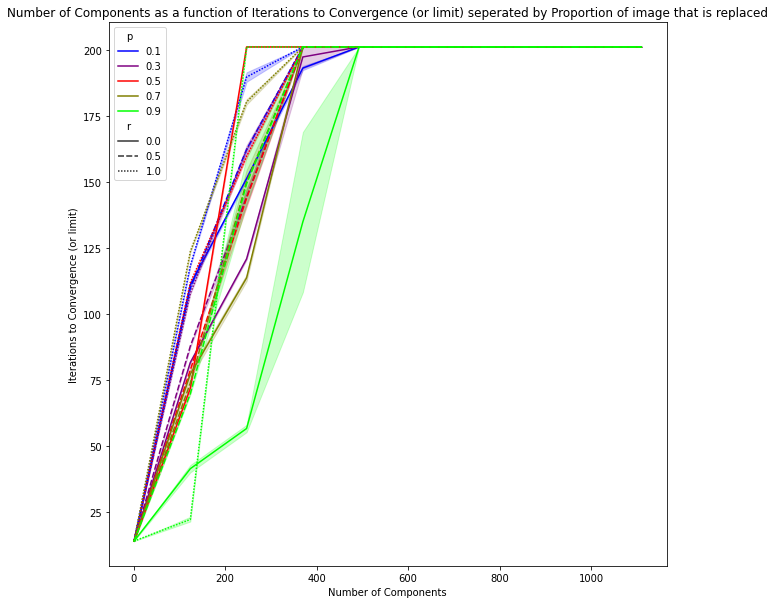

In [7]:
names = dict(
    reconstruction_error = 'Reconstruction Error',
    k='Number of Components',
    r='Proportion of noise that is White',
    p='Proportion of image that is replaced',
    iterations='Iterations to Convergence (or limit)'
)
def plot_aggregate(x, y, color):
    plt.figure(figsize=(10,10))
    plt.title(f'{names[x]} as a function of {names[y]} seperated by {names[color]}')
    plt.xlabel(names[x])
    plt.ylabel(names[y])
    g = sns.lineplot(data=noiserecon_orl, x=x, y=y, hue=color, style='r', palette='brg')
plot_aggregate('k', 'iterations', 'p')

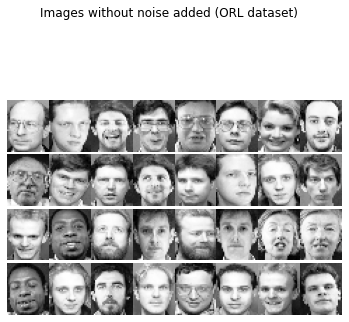

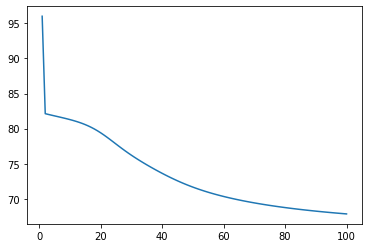

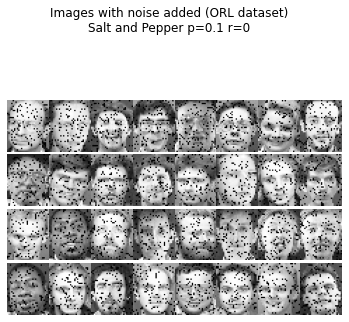

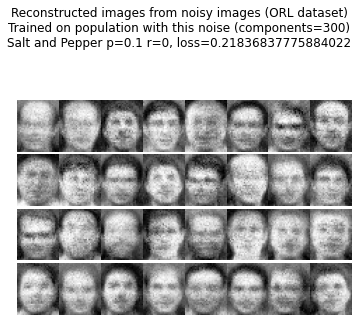

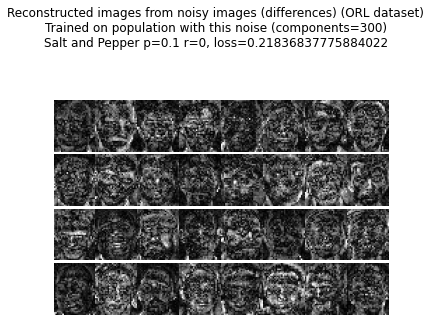

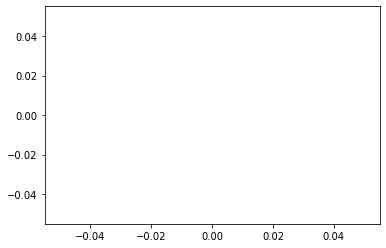

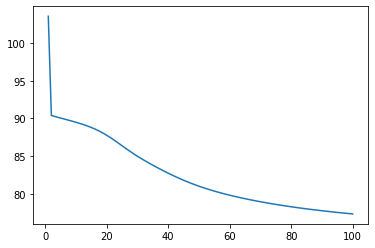

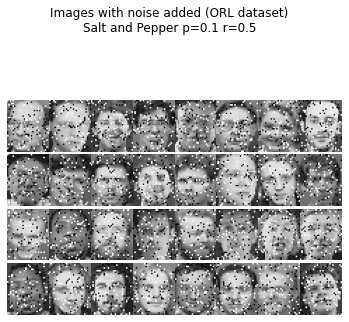

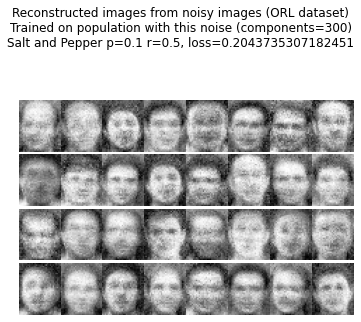

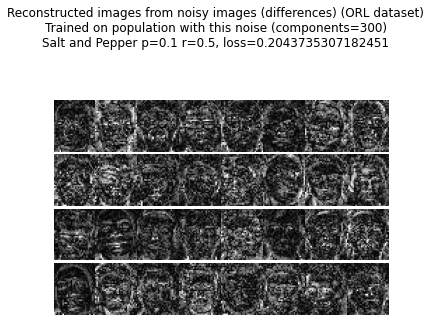

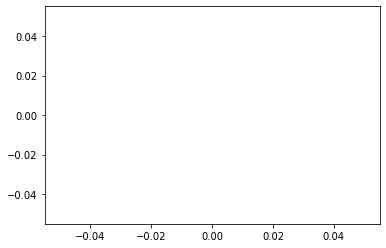

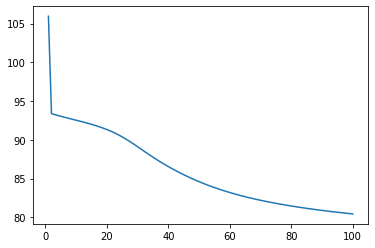

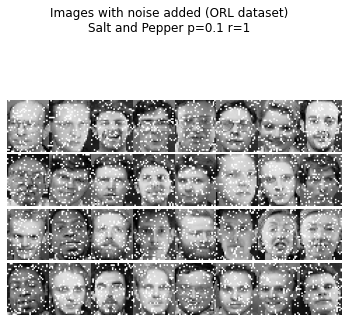

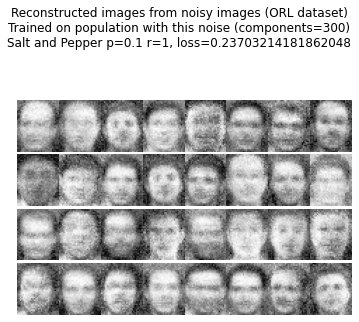

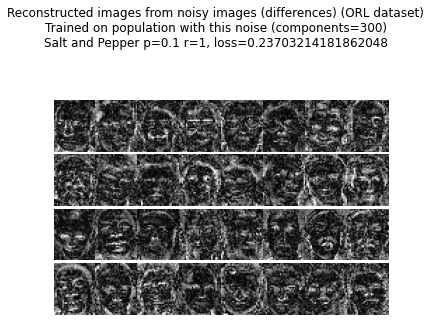

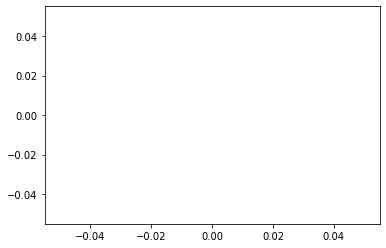

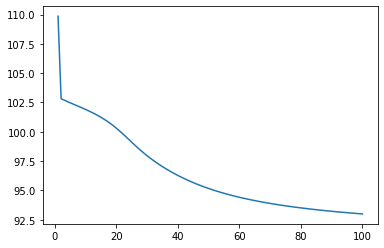

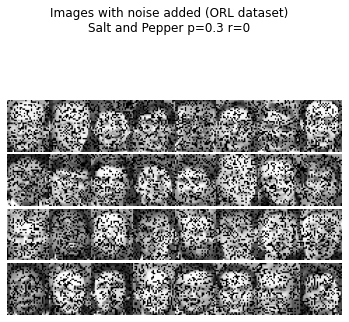

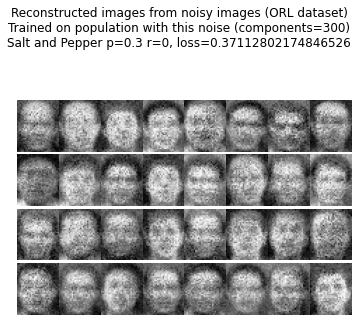

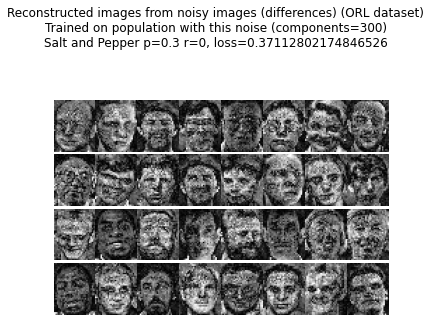

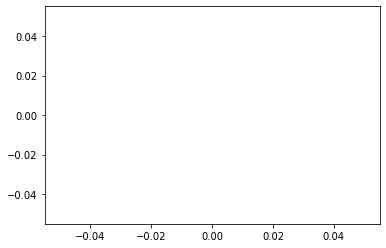

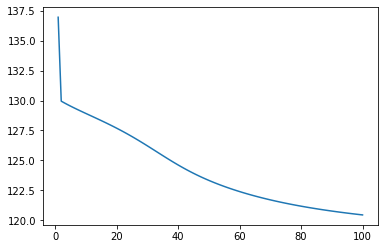

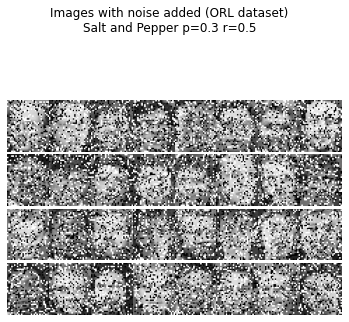

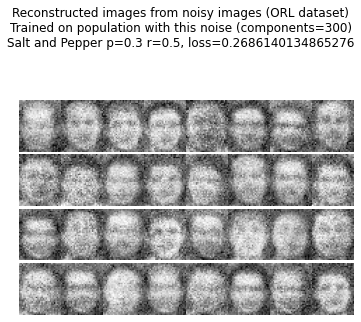

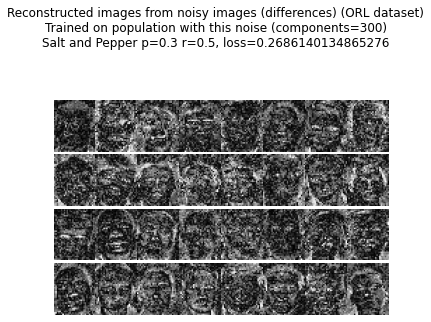

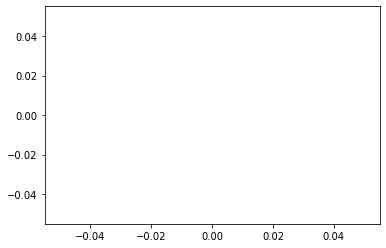

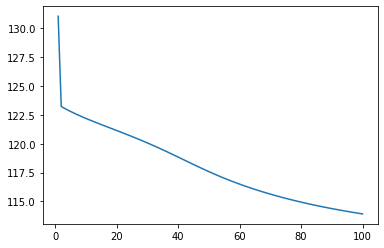

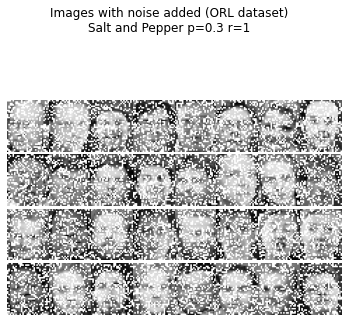

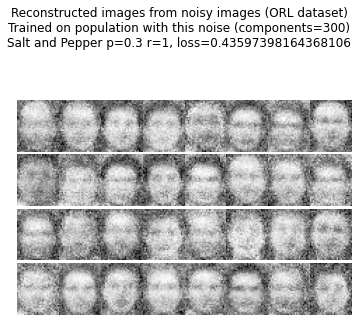

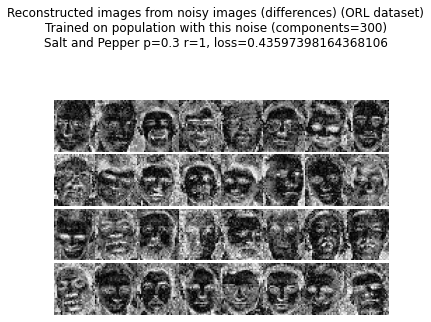

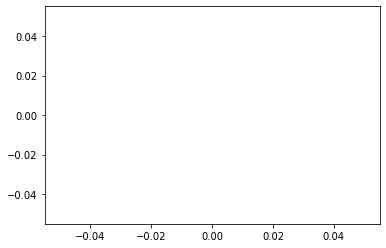

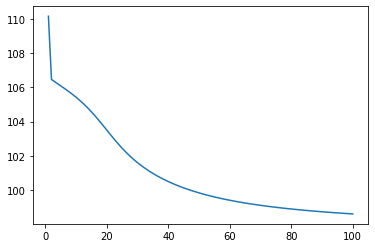

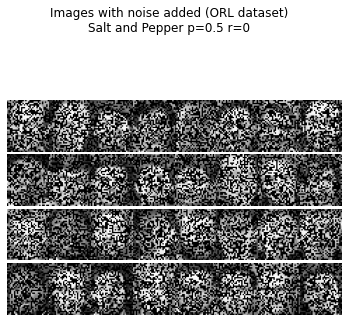

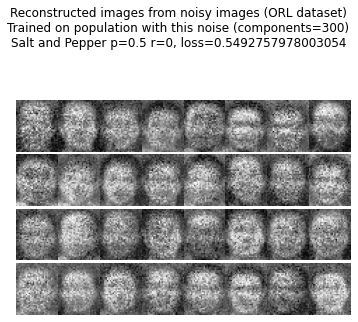

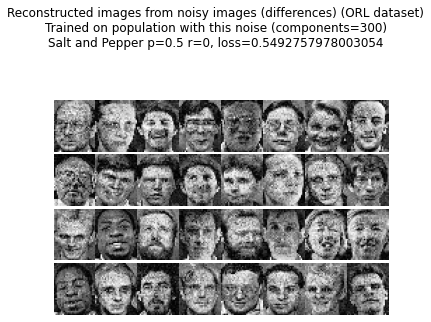

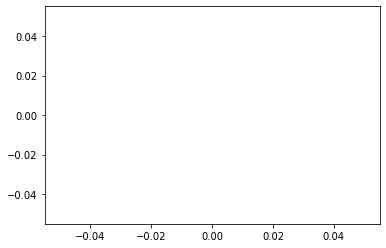

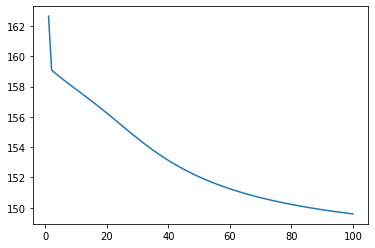

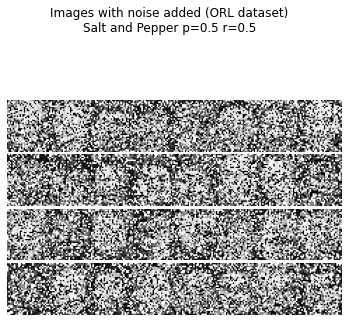

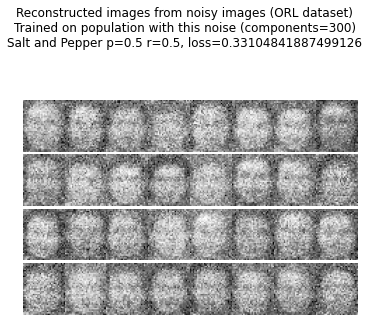

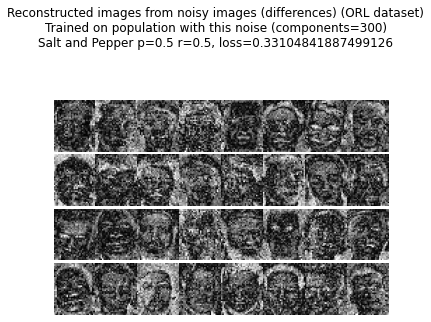

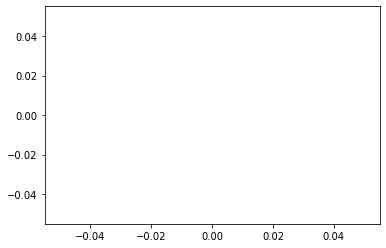

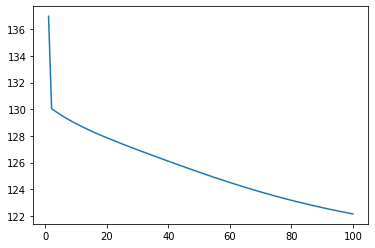

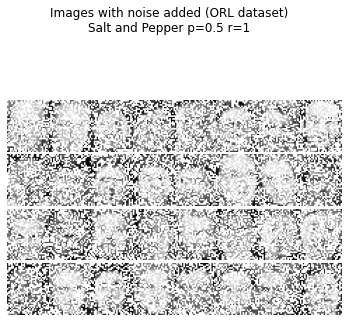

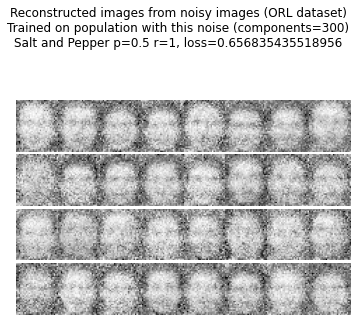

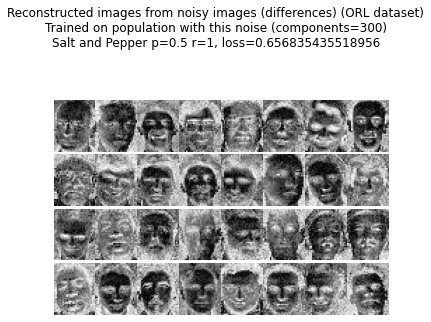

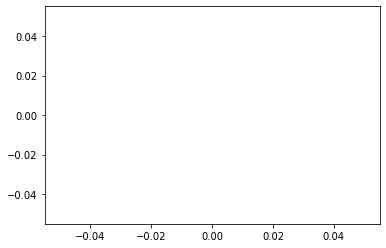

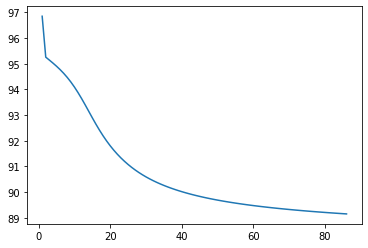

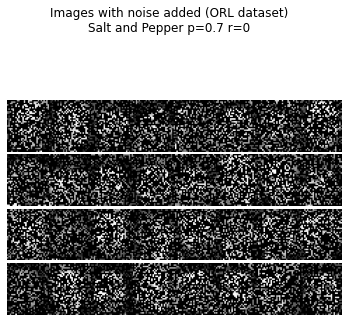

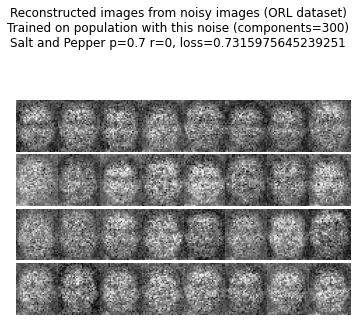

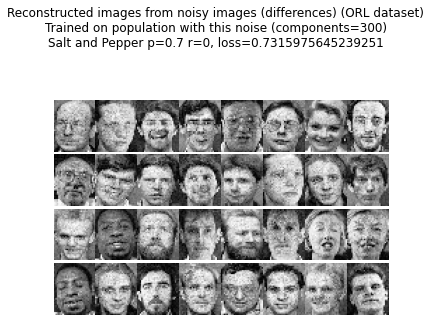

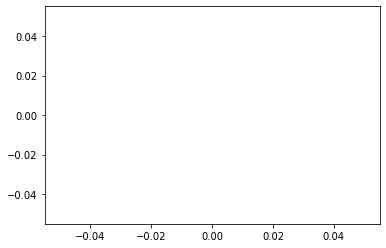

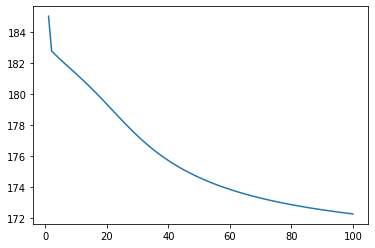

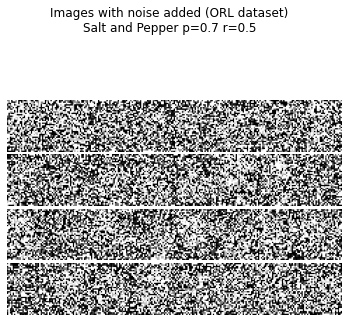

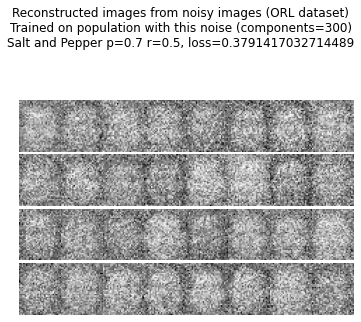

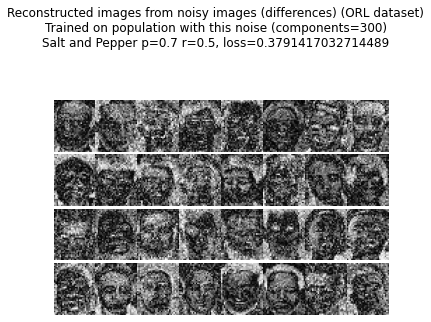

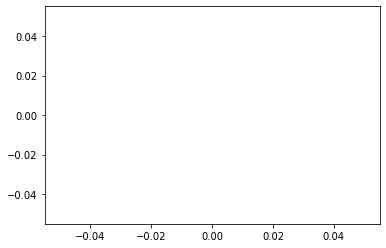

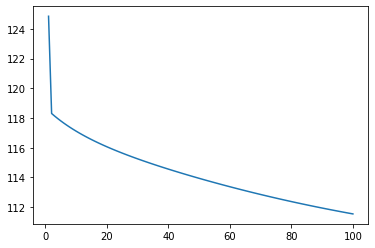

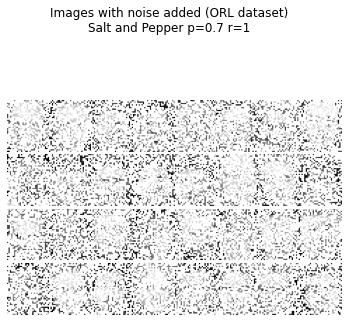

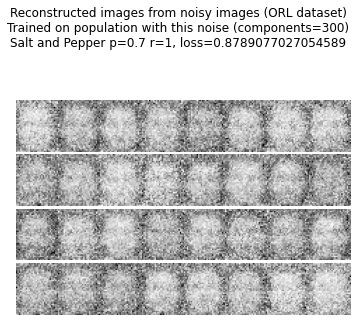

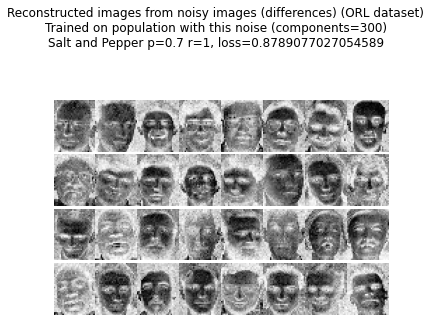

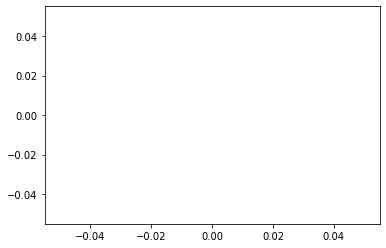

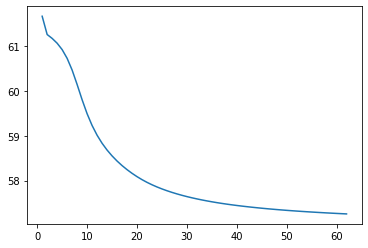

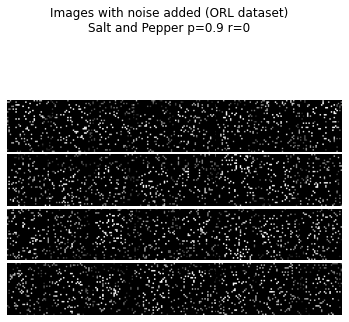

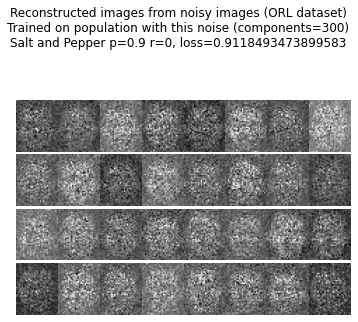

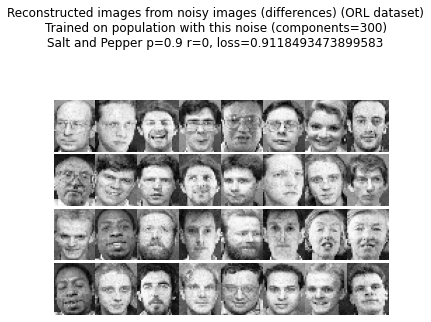

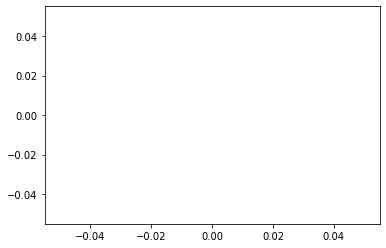

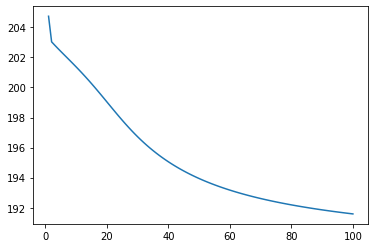

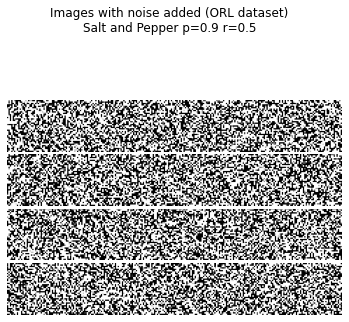

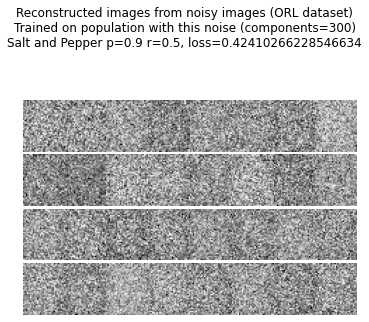

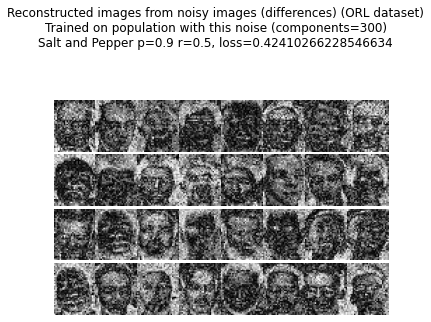

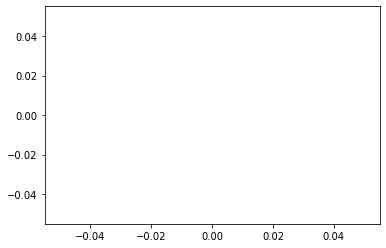

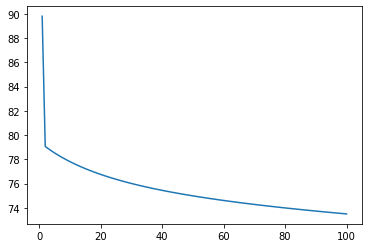

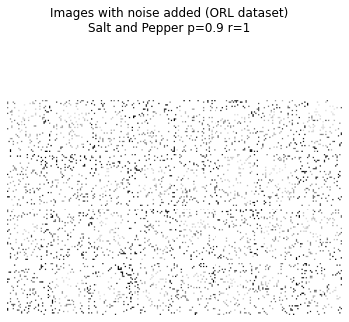

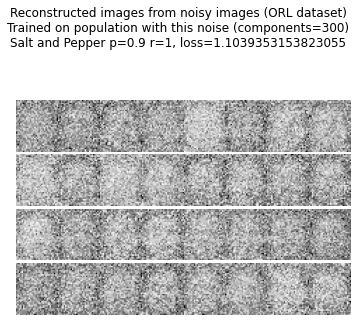

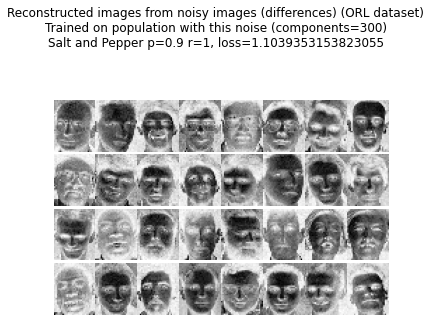

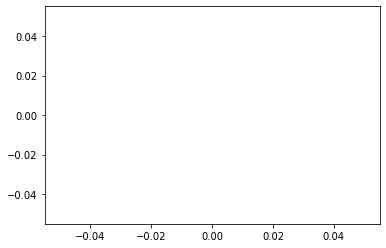

In [19]:
# lets look at some results
show_images(show_orl, f'Images without noise added (ORL dataset)', show_image_dims)
plt.show()
for name, noisefunc in noisefuncs:
    m = L2Norm(30, stop_threshold=0.0001, max_iter=100)#np.product(image_size))
    m.fit(noisefunc(Xo))
    plt.plot(m.get_metavalues()['training_loss'])
    plt.show()
    
    noisy_show = noisefunc(show_orl)
    loss = m.reconstruction_error(noisy_show, show_orl)
    show_images(noisy_show, f'Images with noise added (ORL dataset)\n{name}', show_image_dims)
    plt.show()
    reconstructed = m.inverse_transform(m.transform(noisy_show))
    show_images(reconstructed, f'Reconstructed images from noisy images (ORL dataset)\nTrained on population '
                f'with this noise (components=300)\n{name}, loss={loss}\n\n', show_image_dims)
    plt.show()
    show_images(np.abs(show_orl - reconstructed), f'Reconstructed images from noisy images (differences) (ORL dataset)\nTrained on population '
                f'with this noise (components=300)\n{name}, loss={loss}\n\n', show_image_dims)
    plt.show()
    plt.plot()
    plt.show()


In [9]:
model = L2Norm(1)
model.fit(np.ones(Xo.shape))
model.reconstruction_error(np.ones(show_orl.shape), show_orl)

0.9925414616255257